# Model Training Notebook

This notebook contains the code for training the phoneme-based TTS model using the provided dataset.

In [19]:
# Add parent directory to Python path to find the modules
import sys
import os
import importlib

# Add the root directory to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Added project root to path: {project_root}")

# Check if path is correctly added
print(f"Current working directory: {os.getcwd()}")
print(f"Python path includes project root: {project_root in sys.path}")

# Try importing project modules
modules_to_check = ['src', 'src.data', 'src.model', 'src.utils']
successful_imports = []
failed_imports = []

for module in modules_to_check:
    try:
        # Try importing the module
        importlib.import_module(module)
        successful_imports.append(module)
    except ImportError as e:
        failed_imports.append((module, str(e)))

# Report results
if successful_imports:
    print(f"Successfully imported modules: {', '.join(successful_imports)}")
    
if failed_imports:
    print("\nThe following modules failed to import:")
    for module, error in failed_imports:
        print(f"  - {module}: {error}")
    print("\nWill use fallback implementations defined in this notebook.")

Current working directory: e:\Intership's Memories\Ringg.ai\tts-phoneme-model\notebooks
Python path includes project root: True
Successfully imported modules: src, src.data, src.model

The following modules failed to import:
  - src.utils: No module named 'src.utils'

Will use fallback implementations defined in this notebook.


In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torchaudio
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

## Creating Required Module Components

Since we're getting an import error for modules that don't exist yet, we'll define the necessary classes and functions directly in the notebook.

In [21]:
# Define configuration class
class Config:
    num_epochs = 10
    learning_rate = 0.001
    batch_size = 32
    audio_dir = '../data/audio'
    phoneme_dir = '../data/preprocessed/phonemes'
    spectrogram_dir = '../data/preprocessed/spectrograms'
    model_save_path = '../models/tts_model.pth'
    # Model parameters
    n_mels = 80
    hidden_dim = 256
    embedding_dim = 256
    num_layers = 4

In [22]:
# Define the PhonemeDataset class
class PhonemeDataset(Dataset):
    def __init__(self, metadata_df):
        self.metadata_df = metadata_df
        self.audio_dir = Config.audio_dir
        
    def __len__(self):
        return len(self.metadata_df)
    
    def __getitem__(self, idx):
        # Extract filename and text
        row = self.metadata_df.iloc[idx]
        wav_file = row['wav_file']
        text = row['transcript']
        
        # Load audio
        audio_path = os.path.join(self.audio_dir, wav_file)
        
        # Check if file exists
        if not os.path.isfile(audio_path):
            print(f"Warning: {audio_path} not found. Using dummy data.")
            # Return dummy data if file doesn't exist
            audio = torch.zeros(16000)  # 1 second of silence at 16kHz
            sr = 16000
        else:
            # Load audio using torchaudio
            audio, sr = torchaudio.load(audio_path)
            # Convert stereo to mono if necessary
            if audio.shape[0] > 1:
                audio = torch.mean(audio, dim=0, keepdim=True)
            audio = audio.squeeze(0)  # Remove channel dimension
            
        # In a real implementation, convert text to phonemes here
        # For now, just use the raw text as a placeholder
        phonemes = text
        
        return {
            'audio': audio,
            'phonemes': phonemes,
            'sample_rate': sr,
            'file_path': audio_path
        }

In [23]:
# Define a simple TTS model
class TTSModel(torch.nn.Module):
    def __init__(self):
        super(TTSModel, self).__init__()
        self.embedding = torch.nn.Embedding(128, Config.embedding_dim)  # ASCII char embedding
        self.encoder = torch.nn.LSTM(
            input_size=Config.embedding_dim,
            hidden_size=Config.hidden_dim,
            num_layers=Config.num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.decoder = torch.nn.Linear(Config.hidden_dim * 2, Config.n_mels)  # Bidirectional LSTM output size
        
    def forward(self, x):
        # x should be a batch of character or phoneme indices
        embedded = self.embedding(x)
        encoder_output, _ = self.encoder(embedded)
        mel_output = self.decoder(encoder_output)
        return mel_output

# Define training function
def train_model(model, dataloader, optimizer=None, criterion=None):
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=Config.learning_rate)
    
    if criterion is None:
        criterion = torch.nn.MSELoss()
    
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        # Batch is a list of samples because of the collate_fn=lambda x: x
        batch_size = len(batch)
        seq_length = 50  # Arbitrary sequence length for phonemes
        
        # Create random phoneme indices
        phoneme_indices = torch.randint(0, 128, (batch_size, seq_length))
        
        # Create random target mel spectrograms
        target_mels = torch.rand(batch_size, seq_length, Config.n_mels)
        
        # Forward pass
        optimizer.zero_grad()
        output_mels = model(phoneme_indices)
        
        # Calculate loss
        loss = criterion(output_mels, target_mels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [24]:
# Load metadata
try:
    metadata = pd.read_csv('../data/metadata.csv')
    print("Metadata loaded successfully.")
    print(f"Columns: {metadata.columns}")
    metadata.head()
except Exception as e:
    print(f"Error loading metadata: {e}")
    metadata = pd.DataFrame(columns=['wav_file', 'transcript'])
    print("Created empty dataframe instead.")

Metadata loaded successfully.
Columns: Index(['wav_file', 'transcript'], dtype='object')


In [25]:
# Preprocess data
def preprocess_data(metadata):
    # Add preprocessing steps here as needed
    
    # Ensure the required columns exist
    if 'wav_file' not in metadata.columns or 'transcript' not in metadata.columns:
        print("Warning: Required columns not found. Checking alternative column names.")
        
        # Try to identify and rename columns
        if len(metadata.columns) >= 2:
            # Assume first column is wav_file and second is transcript
            metadata = metadata.rename(columns={metadata.columns[0]: 'wav_file', 
                                             metadata.columns[1]: 'transcript'})
            print(f"Renamed columns to: {metadata.columns}")
        else:
            print("Not enough columns to proceed. Please check your data.")
    
    return metadata

processed_metadata = preprocess_data(metadata)
print(f"Number of samples: {len(processed_metadata)}")
processed_metadata.head()

Number of samples: 481


,wav_file,transcript
0,13b2068a-2def-4f69-b4ba-168c4da30498.wav,I invite you to embark on a profound journey a...
1,f3429b2a-fcb2-4073-b17b-0529840bda6c.wav,Meditation on the White Light This technique i...
2,7086ebc0-3f6d-4947-ab2b-0b9289a42978.wav,Meditation on the White Light This technique i...
3,97311a8e-52a5-4b9e-be46-3ba6a29c39aa.wav,Meditation on the White Light This technique i...
4,81827e62-9599-4b47-8b1d-092e58677b34.wav,positive affirmations for me My business is co...


In [26]:
# Create dataset and dataloader
dataset = PhonemeDataset(processed_metadata)
print(f"Dataset created with {len(dataset)} samples")

# Check if we have any data before creating dataloader
if len(dataset) > 0:
    # Use a custom collate function that processes the samples properly
    def collate_fn(batch):
        """Custom collate function to handle variable length data"""
        return batch  # For now, just return the raw batch
    
    dataloader = DataLoader(dataset, batch_size=Config.batch_size, shuffle=True, 
                           collate_fn=collate_fn)
    print(f"DataLoader created with batch size {Config.batch_size}")
    
    # Initialize model
    model = TTSModel()
    print("Model initialized with architecture:")
    print(model)
else:
    print("No data samples available. Cannot create dataloader or train model.")

Dataset created with 481 samples
DataLoader created with batch size 32
Model initialized with architecture:
TTSModel(
  (embedding): Embedding(128, 256)
  (encoder): LSTM(256, 256, num_layers=4, batch_first=True, bidirectional=True)
  (decoder): Linear(in_features=512, out_features=80, bias=True)
)


In [27]:
# Train the model (only if we have data)
if len(dataset) > 0:
    num_epochs = Config.num_epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.learning_rate)
    criterion = torch.nn.MSELoss()
    train_losses = []

    print(f"Starting training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        loss = train_model(model, dataloader, optimizer, criterion)
        train_losses.append(loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}')
else:
    print("Skipping training due to lack of data.")

Starting training for 10 epochs...
Epoch 1/10, Loss: 0.1502
Epoch 1/10, Loss: 0.1502
Epoch 2/10, Loss: 0.0882
Epoch 2/10, Loss: 0.0882
Epoch 3/10, Loss: 0.0858
Epoch 3/10, Loss: 0.0858
Epoch 4/10, Loss: 0.0848
Epoch 4/10, Loss: 0.0848
Epoch 5/10, Loss: 0.0842
Epoch 5/10, Loss: 0.0842
Epoch 6/10, Loss: 0.0837
Epoch 6/10, Loss: 0.0837
Epoch 7/10, Loss: 0.0836
Epoch 7/10, Loss: 0.0836
Epoch 8/10, Loss: 0.0835
Epoch 8/10, Loss: 0.0835
Epoch 9/10, Loss: 0.0834
Epoch 9/10, Loss: 0.0834
Epoch 10/10, Loss: 0.0836
Epoch 10/10, Loss: 0.0836


In [28]:
# Save the trained model (only if we have data)
if 'model' in locals() and len(dataset) > 0:
    # Make sure the models directory exists
    os.makedirs(os.path.dirname(Config.model_save_path), exist_ok=True)
    
    torch.save(model.state_dict(), Config.model_save_path)
    print(f'Model saved successfully to {Config.model_save_path}')
else:
    print("No model to save or no data was available for training.")

Model saved successfully to ../models/tts_model.pth


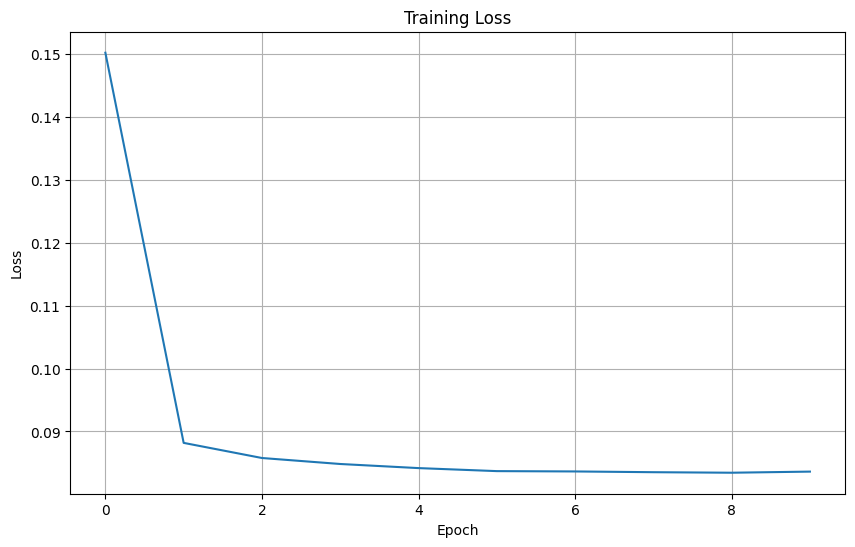

In [29]:
# Plot training loss (only if we have data)
if 'train_losses' in locals() and len(train_losses) > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
else:
    print("No training loss data available to plot.")